In [6]:
import torch
import cv2
import matplotlib.pyplot as plt
from model import TransferLearning, TorchUNET, CustomUNET1, CustomUNET2
import argparse
import os
from time import time
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from tqdm import tqdm

In [7]:
MODELS_FOLDER = "../models"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATA_PATH = "../inputs/nyu_data/data/nyu2_test"
MODEL_CLASS = "custom-UNET"
MODEL_GEN = "gen-2"

MODEL_PATH = os.path.join(MODELS_FOLDER, MODEL_CLASS, MODEL_GEN)

POOL_SIZE = 3
STRIDE = (POOL_SIZE - 1) // 2

In [8]:
for model in os.listdir(MODEL_PATH):
    tokens = model.split(".")
    if tokens[0] == "3" or tokens[0] == "7":
        model_path = model 

if MODEL_CLASS == "torch-UNET":
    torchUNET = TorchUNET()
    depth_model = torchUNET.get_model().to(DEVICE)
    depth_model.load_state_dict(
        torch.load(os.path.join(MODEL_PATH, model_path), map_location=DEVICE, weights_only=True)
    )

elif MODEL_CLASS == "Transfer-Learning":
    depth_model = TransferLearning().to(DEVICE)
    depth_model.load_state_dict(
        torch.load(os.path.join(MODEL_PATH, model_path), map_location=DEVICE, weights_only=True)
    )

elif MODEL_CLASS == "custom-UNET" and MODEL_GEN == "gen-1":
    depth_model = CustomUNET1().to(DEVICE)
    depth_model.load_state_dict(
        torch.load(os.path.join(MODEL_PATH, model_path), map_location=DEVICE, weights_only=True)
    )

elif MODEL_CLASS == "custom-UNET" and MODEL_GEN == "gen-2":
    depth_model = CustomUNET2().to(DEVICE)
    depth_model.load_state_dict(
        torch.load(os.path.join(MODEL_PATH, model_path), map_location=DEVICE, weights_only=True)
    )

In [9]:
image_data = {}

"""
STORAGE FORMAT:
{
    key1 : [image1, depth1],
    key2 : [image2, depth2]
}
"""

# Read images from the given path
image_files = os.listdir(DATA_PATH)

# Classify and store images based on their endings
for image_file in tqdm(image_files, desc="Processing images"):
    image_name, ext = os.path.splitext(image_file)
    key = image_name.split("_")[0]  # Extract the part before '_'

    image_path = os.path.join(DATA_PATH, image_file)

    if image_file.endswith("_depth.png"):
        if key in image_data:
            image_data[key] = (image_data[key][0], cv2.imread(image_path))
        else:
            image_data[key] = (None, cv2.imread(image_path))

    elif image_file.endswith("_colors.png"):
        if key in image_data:
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_data[key] = (image, image_data[key][1])
        else:
            image_data[key] = (cv2.imread(image_path), None)

Processing images: 100%|██████████| 1308/1308 [00:08<00:00, 146.87it/s]


In [10]:
outputs = []

progress_bar = tqdm(image_data.items(), desc="Evaluating", total=len(image_data))

for key, (color_img, ground_truth) in progress_bar:

    image_tensor = (
        torch.from_numpy(cv2.resize(color_img, (320, 240)))
        .float()
        .permute(2, 0, 1)
        .unsqueeze(0)
        .to(DEVICE)
    )

    with torch.no_grad():
        start = time()
        predicted = depth_model(image_tensor).cpu().squeeze().numpy()
        end = time()
    
    inference_time = end - start

    predicted_min = predicted.min()
    predicted_max = predicted.max()
    predicted = (predicted - predicted_min) / (predicted_max - predicted_min)

    progress_bar.set_description(f"Evaluating (Inference Time: {inference_time:.4f} s/image)")

    outputs.append((color_img, ground_truth, predicted))

Evaluating (Inference Time: 0.0411 s/image): 100%|██████████| 654/654 [00:28<00:00, 22.79it/s]


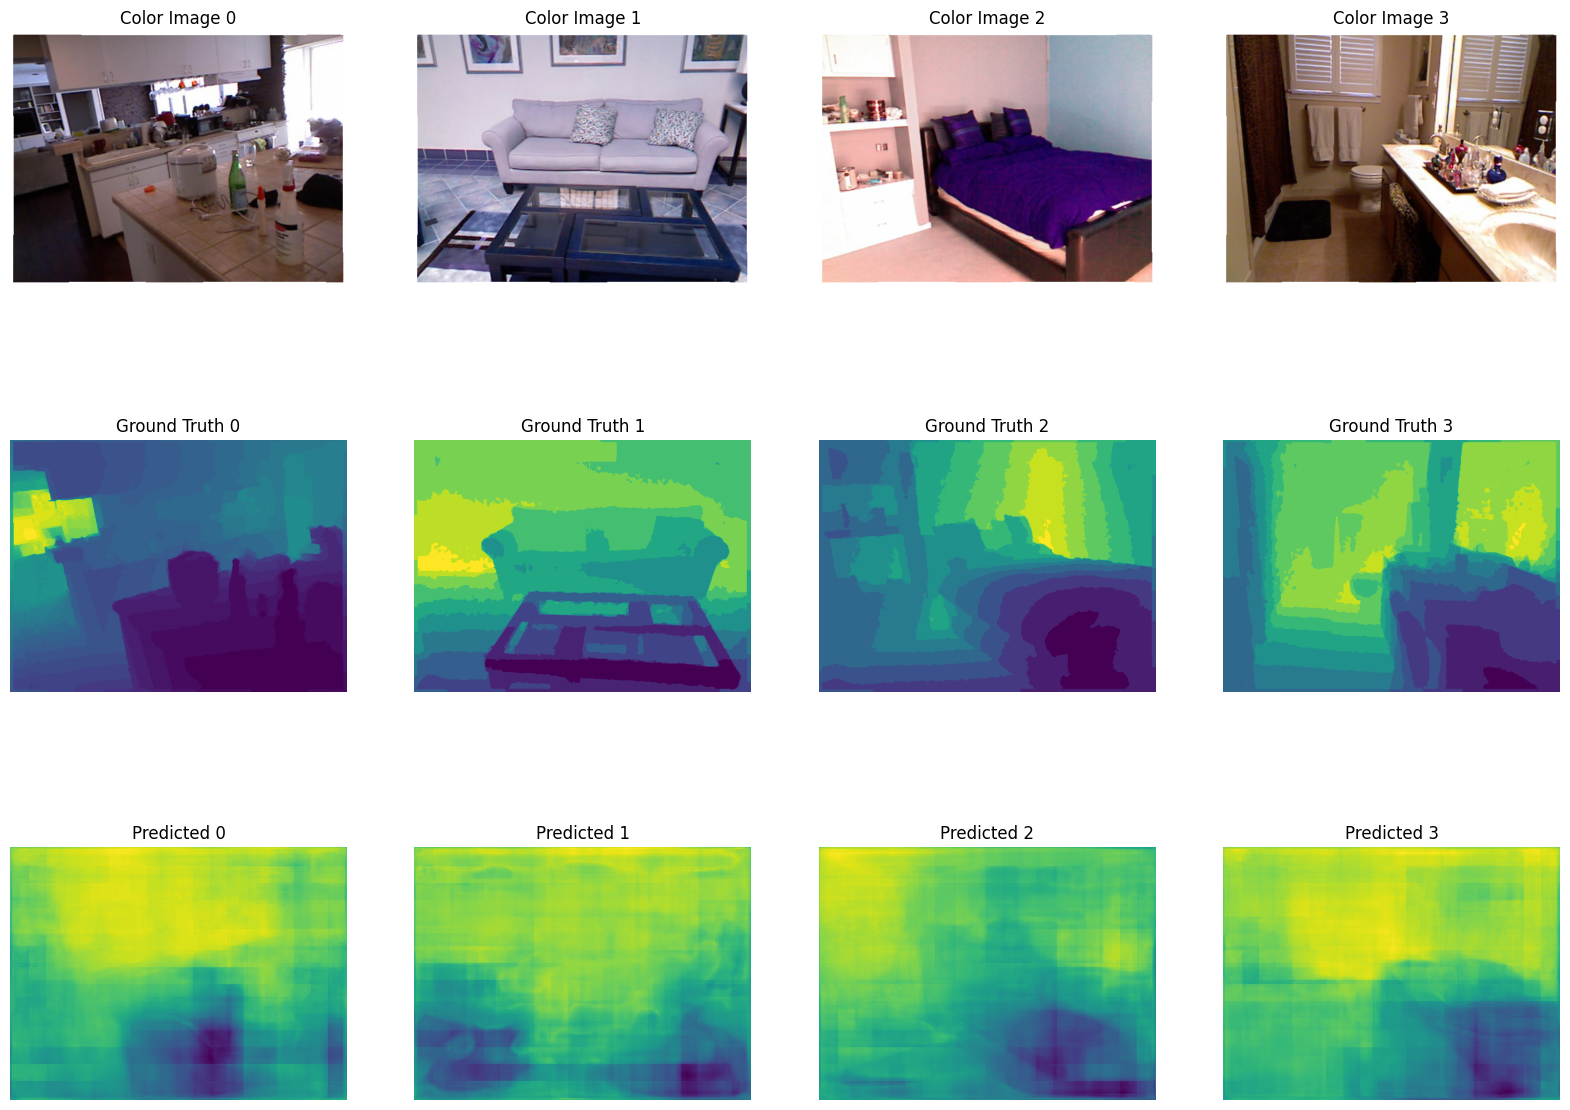

In [11]:
# Create a 3x4 grid for plotting
fig, axs = plt.subplots(3, 4, figsize=(20, 15))

for i, (color_img, ground_truth, predicted) in enumerate(outputs):
    if i == 4:  # Display only the first 12 triplets (adjust based on your grid size)
        break

    # Convert color_img to RGB for matplotlib
    color_img_rgb = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)

    # Display color image
    axs[0, i].imshow(color_img_rgb)
    axs[0, i].set_title(f"Color Image {i}")
    axs[0, i].axis('off')

    # Display ground truth image (assumed to be grayscale)
    axs[1, i].imshow(cv2.cvtColor(ground_truth, cv2.COLOR_BGR2GRAY), cmap='viridis')
    axs[1, i].set_title(f"Ground Truth {i}")
    axs[1, i].axis('off')

    # Display predicted image (assumed to be grayscale)
    axs[2, i].imshow(1 - predicted, cmap='viridis')
    axs[2, i].set_title(f"Predicted {i}")
    axs[2, i].axis('off')

In [12]:

def calculate_average_relative_error(gt_image, predicted_image):
    # Ensure GT and predicted images are numpy arrays
    gt_image = np.array(gt_image, dtype=np.float32)
    predicted_image = np.array(predicted_image, dtype=np.float32)

    # Convert GT image to grayscale if it's not already
    if len(gt_image.shape) == 3:  # RGB or other multi-channel image
        gt_image = cv2.cvtColor(gt_image, cv2.COLOR_RGB2GRAY)
    
    # Resize predicted image to match GT image shape
    predicted_image = 1 - predicted_image
    predicted_image = cv2.resize(predicted_image, (gt_image.shape[1], gt_image.shape[0]), interpolation=cv2.INTER_LANCZOS4)

    # Median scaling step: scale the predicted depth map to match the median of the ground truth
    median_gt = np.median(gt_image)
    median_predicted = np.median(predicted_image)

    # Avoid division by zero in case the predicted median is 0
    if median_predicted != 0:
        scale_factor = median_gt / median_predicted
        predicted_image *= scale_factor

    # Calculate absolute difference
    diff_image = np.abs(predicted_image - gt_image)

    # Calculate relative error
    ratio_image = diff_image / gt_image

    # Accumulate the relative errors
    acc = np.sum(ratio_image)

    return acc

In [13]:
total_relative_error = 0
num_images = len(outputs)

for i, (color_img, ground_truth, predicted) in enumerate(outputs):
    total_relative_error += calculate_average_relative_error(ground_truth, predicted)

# Calculate average relative error
average_relative_error = total_relative_error / (num_images * 640 * 480 * 6)

print(f"Average Relative Error: {average_relative_error}")

Average Relative Error: 0.04404741321742595
